In [74]:
import math
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier  
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix  

In [75]:
train_data = pd.read_csv('Data/data_train.csv', header=None).values
test_data = pd.read_csv('Data/data_test.csv', header=None).values

In [76]:
def calculate_precision(evaluated, exact):
    tp = 0
    fp = 0
    for i in range(len(evaluated)):
        if  evaluated[i] == exact[i]:
            tp += 1
        else:
            fp += 1
    return tp / (fp + tp)

In [77]:
def choise_random_matrix(matrix):
    return matrix[np.random.choice(matrix.shape[0], matrix.shape[0], replace=True), :]

def choise_random_feature(matrix, number):
    index = np.append(np.random.choice(matrix.shape[1]-1, number, replace=False),-1)
    return index

In [78]:
def tree(depth, X_train, y_train, X_test):
    classifier = DecisionTreeClassifier(max_depth=depth, random_state = 100)  
    classifier.fit(X_train, y_train)  
    return classifier.predict(X_test) 


def random_forest(number, depth, train, test):
    evaluated_labels = np.zeros((number, test.shape[0]))
    for i in range(number):
        random_train = choise_random_matrix(train)
        features_index = choise_random_feature(train, depth)
        new_train = random_train[:, features_index]
        new_test = test[:, features_index]
        t = tree(depth, new_train[:,:-1], new_train[:,-1], new_test[:,:-1])
        evaluated_labels[i] = t
    
    evaluated_y = np.array([max(map(lambda val: (list(array).count(val), val), set(array)))[1] for array in evaluated_labels.T])
    return evaluated_y

In [79]:

def evaluate_test(k, tests, trains):
    evaluated_label = random_forest(15, k, train_data, test_data)
    print('depth is :', k)
    print(' precision = :', calculate_precision(evaluated_label, tests[:,-1]))
    print('confustion matrix : \n', confusion_matrix(tests[:,-1], evaluated_label))
    print('classification report : \n', classification_report(tests[:,-1], evaluated_label)) 

In [80]:
depth = [2,3,4,5,6]

for d in depth:
    evaluate_test(d, test_data, train_data)

depth is : 2
 precision = : 0.5042881646655232
confustion matrix : 
 [[267  11   4   7  74   0   0   0   0   0]
 [  0 120 155  42   1   0  46   0   0   0]
 [  0   0 355   8   1   0   0   0   0   0]
 [  0   1   1 332   2   0   0   0   0   0]
 [  0   0   0   5 336   0  23   0   0   0]
 [ 17   1   3 138  30 117  29   0   0   0]
 [  0   0   6  44  61   0 223   2   0   0]
 [  0  11 250  38  48   2   1  14   0   0]
 [149   1 120   4  42  10   9   1   0   0]
 [  0  14   0 235  59   0  28   0   0   0]]
classification report : 
              precision    recall  f1-score   support

          0       0.62      0.74      0.67       363
          1       0.75      0.33      0.46       364
          2       0.40      0.98      0.56       364
          3       0.39      0.99      0.56       336
          4       0.51      0.92      0.66       364
          5       0.91      0.35      0.50       335
          6       0.62      0.66      0.64       336
          7       0.82      0.04      0.07       

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


depth is : 3
 precision = : 0.7015437392795884
confustion matrix : 
 [[305   0  12   0   1   0  23   0  22   0]
 [  0 137 175  41   0   0   1  10   0   0]
 [  0   3 360   0   1   0   0   0   0   0]
 [  0   6   1 329   0   0   0   0   0   0]
 [  1   0   2   0 350   0   9   2   0   0]
 [  0   0   2 152   5 164   7   4   0   1]
 [  2   0   7   3   2   0 320   2   0   0]
 [  6  29  26   7  14   3   9 269   1   0]
 [ 79   0  10   2   0  30   0  17 198   0]
 [  0  42   0 260  11   0   0   1   0  22]]
classification report : 
              precision    recall  f1-score   support

          0       0.78      0.84      0.81       363
          1       0.63      0.38      0.47       364
          2       0.61      0.99      0.75       364
          3       0.41      0.98      0.58       336
          4       0.91      0.96      0.94       364
          5       0.83      0.49      0.62       335
          6       0.87      0.95      0.91       336
          7       0.88      0.74      0.80       

In [99]:
def tree(depth, X_train, y_train, weights):
    classifier = DecisionTreeClassifier(max_depth=depth)  
    classifier.fit(X_train, y_train, sample_weight=weights)  
    return classifier.predict(X_train), classifier 

In [100]:
def best_class(alfas, classes):
    new_classes = np.array(classes)
    alfas = np.array(alfas)*classes
    d = dict()
    for i in range(len(new_classes)):
        if new_classes[i] in d:
            d[new_classes[i]] += alfas[i]
        else:
            d[new_classes[i]] = alfas[i]
    m = [key for key, value in d.items() if value == max(d.values())]
    return m[0]

In [125]:
import matplotlib.pyplot as plt
import numpy as np
def diagram(x,y):
    plt.gca()
    plt.plot(x, y)
    plt.show()

In [126]:
def adaboost(number, depth, train, test, show_diagram = False):
    weights = np.array([1/train.shape[0]]*train.shape[0])
    alfas = list()
    trees = list()
    classes = np.unique(train[:,-1])
    number_of_class = len(classes)
    for i in range(number):
        epsilon = 1.1
        while epsilon >= 1-(1/number_of_class):
            new_train = choise_random_matrix(train)
            evaluated_train_y, tree_ = tree(depth, new_train[:,:-1], new_train[:,-1], weights)
            incorrect_index = [i for i in range(train.shape[0]) if train[i,-1] != evaluated_train_y[i]]
            incorrect_weight = sum(weights[incorrect_index])
            whole_weight = sum(weights)
            epsilon = incorrect_weight/whole_weight
        alfa = math.log((1-epsilon)/epsilon) + math.log(number_of_class-1)
        weights[incorrect_index] = weights[incorrect_index] * math.exp(alfa)
        alfas.append(alfa)
        trees.append(tree_)
    if show_diagram:
        diagram([i for i in range(number)], alfas)
    evaluated_labels = np.array([t.predict(test[:,:-1]) for t in trees]).T
    evaluated_label = np.array([best_class(alfas, t) for t in evaluated_labels])
    return evaluated_label
#     evaluated_label = np.array([ for t in test])

In [127]:
def evaluate_test(depth, tests, trains):
    evaluated_label = adaboost(10, depth, train_data, test_data)
    print('depth is :', depth)
    print('confustion matrix : \n', confusion_matrix(tests[:,-1], evaluated_label))
    print('classification report : \n', classification_report(tests[:,-1], evaluated_label)) 


In [128]:
depth = [i for i in range(2,13,2)]
for d in depth:
    evaluate_test(d, test_data, train_data)

depth is : 2
confustion matrix : 
 [[307   0   0   0  23  25   0   8   0   0]
 [  0   0   0   0  27   0   0 337   0   0]
 [  0   0   0   0  20   0   0 344   0   0]
 [  0   0   0   0   1   0   0 335   0   0]
 [  0   0   0   0 356   0   0   8   0   0]
 [  0   0   0   0  68 168   0  99   0   0]
 [  2   0   0   0 297   4   0  33   0   0]
 [  0   0   0   0  29  11   0 324   0   0]
 [ 42   0   0   0  46 213   0  35   0   0]
 [  1   0   0   0 163   0   0 172   0   0]]
classification report : 
              precision    recall  f1-score   support

          0       0.87      0.85      0.86       363
          1       0.00      0.00      0.00       364
          2       0.00      0.00      0.00       364
          3       0.00      0.00      0.00       336
          4       0.35      0.98      0.51       364
          5       0.40      0.50      0.44       335
          6       0.00      0.00      0.00       336
          7       0.19      0.89      0.31       364
          8       0.00      0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


depth is : 4
confustion matrix : 
 [[297   0   0   1   3   0   0   7  47   8]
 [  0   0 169 154   0   0   0   0  17  24]
 [  0   0 300  21   2   0   0  13  21   7]
 [  0   0   0 324   1   0   0   0  11   0]
 [  0   0   0   6 300   0   0   0   0  58]
 [  0   0   0  87   0 150   0   0  20  78]
 [  1   0   1  17  10   0 271   0  18  18]
 [  0   0   4  30   0   0   0 261  37  32]
 [  2   0   0   0   0   0   0  15 315   4]
 [  0   0   0 150  17   0   0   0   9 160]]
classification report : 
              precision    recall  f1-score   support

          0       0.99      0.82      0.90       363
          1       0.00      0.00      0.00       364
          2       0.63      0.82      0.72       364
          3       0.41      0.96      0.58       336
          4       0.90      0.82      0.86       364
          5       1.00      0.45      0.62       335
          6       1.00      0.81      0.89       336
          7       0.88      0.72      0.79       364
          8       0.64      0.

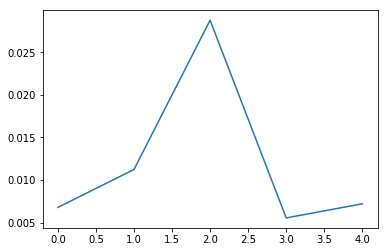

number of iteration is :  5
error is :  0.9173813607775871


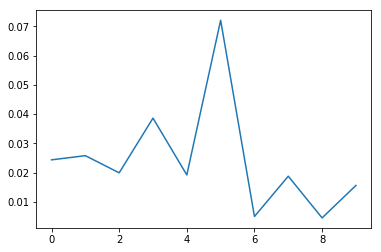

number of iteration is :  10
error is :  0.906232132647227


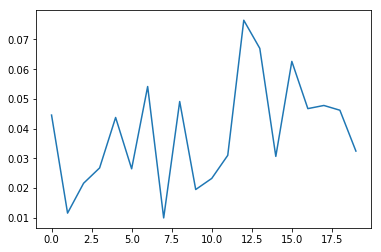

number of iteration is :  20
error is :  0.9222412807318467


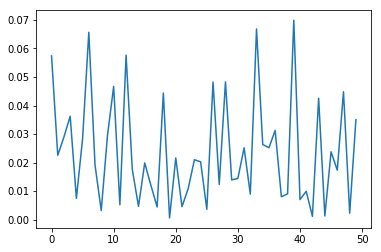

number of iteration is :  50
error is :  0.9331046312178388


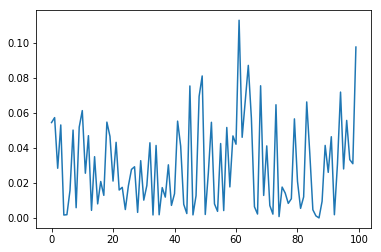

number of iteration is :  100
error is :  0.934819897084048


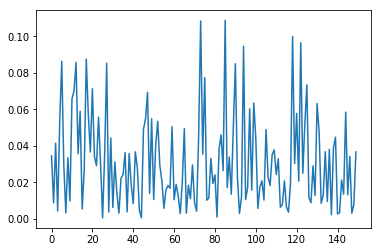

number of iteration is :  150
error is :  0.9322469982847341


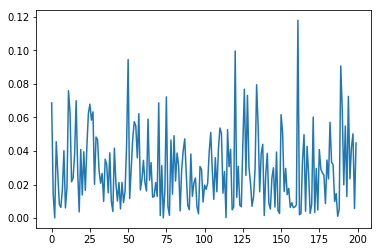

number of iteration is :  200
error is :  0.9336763865065751


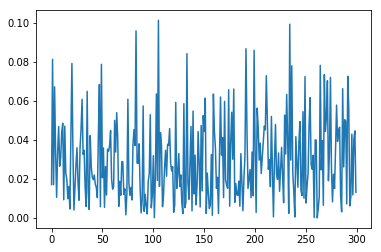

number of iteration is :  300
error is :  0.933390508862207


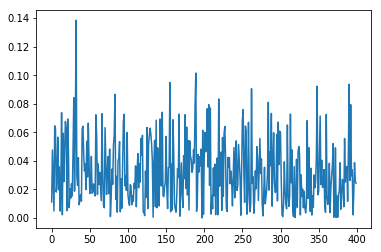

number of iteration is :  400
error is :  0.9331046312178388


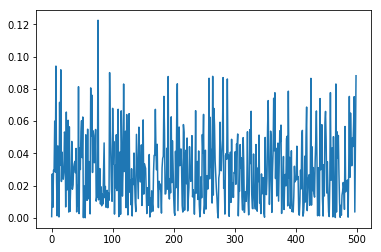

number of iteration is :  500
error is :  0.931961120640366


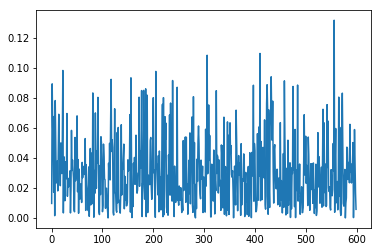

number of iteration is :  600
error is :  0.9296740994854202
diagram of errors: 


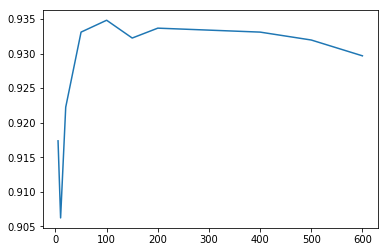

In [129]:
t = [5,10,20,50,100, 150, 200,300,400,500, 600]
precision_errors = list()
for i in range(len(t)):
    evaluated_label = adaboost(t[i], 10, train_data, test_data, show_diagram = True)
    precision_errors.append(calculate_precision(evaluated_label, test_data[:,-1]))
    print('number of iteration is : ', t[i])
    print('error is : ', precision_errors[i])
print('diagram of errors: ')
diagram(t, precision_errors)
    


In [ ]:

number of iteration is :  5
error is :  0.9173813607775871

number of iteration is :  10
error is :  0.906232132647227

number of iteration is :  20
error is :  0.9222412807318467

number of iteration is :  50
error is :  0.9331046312178388

number of iteration is :  100
error is :  0.934819897084048

number of iteration is :  150
error is :  0.9322469982847341

number of iteration is :  200
error is :  0.9336763865065751

number of iteration is :  300
error is :  0.933390508862207

number of iteration is :  400
error is :  0.9331046312178388

number of iteration is :  500
error is :  0.931961120640366

number of iteration is :  600
error is :  0.9296740994854202



<div style="direction:rtl;line-height:300%;"><font face="XB Zar" size=5>
adaboost
    چند کلاسه با استفاده از الگوریتم 
    SAMME
    پیاده سازی شده و نمودارها، وزنهای هر درخت تصمیم گیری در مرحله‌های متناظر هستند که همانطور که در شکلها آمده وزن ها نباید منفی باشند چون در محاسبه رابطه وزن از یک ترم ثابت یعنی لگاریتم منهای یک تعداد کلاسها استفاده کرده‌ایم و بازه ی این وزن ها از ۰ تا ۰.۱ می‌باشد. 
    همچنین برای تعداد تکرارهای بیشتر از ۱۵۰، با افزایش وزن‌ها در دورهای انتهایی وزن نیز باید کاهش یافته است و در نمودار انتهایی می بینیم که با بیشتر شدن تکرار ها دقت دسته بند 
    Adaboost
    .بهتر شده است
در واقع با تعداد تکرارهای خیلی زیاد تا زمانی که به مقدار ثابتی میل کند و عمق بالای درخت ها موجب قوی شدن این دسته بند میشوند و دورهای ابتدایی 
    adaboost و توقف در این مراحل بایاس کم به ما میدهد  ولی با تعداد دور بیشتر و عدم توقف واریانس کاهش می یابد.
    <br>
    نمودار انتهایی خطا بر حسب تعداد دورها را نشان میدهد.
</font>
    </div>